In [4]:
from functools import partial
import time

import jax
import jax.numpy as jnp
import jax.random as jrand

import matplotlib.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

import graphax
from graphax import jacve

In [2]:
font = {"family" : "normal",
        "weight" : "normal",
        "size"   : 14}

plt.rc('font', **font)

In [5]:
@partial(jax.vmap, in_axes=(0, None, None, None, None, 0))
def NeuralNetwork(x, W1, b1, W2, b2, y):
				y1 = W1 @ x
				z1 = y1 + b1
				a1 = jnp.tanh(z1)
				
				y2 = W2 @ a1
				z2 = y2 + b2
				return 0.5*(jnp.tanh(z2) - y)**2

def f(x, W1, b1, W2, b2, y):
				out = NeuralNetwork(x, W1, b1, W2, b2, y)
				return out.sum()
   
jax_runtimes, runtimes = [], []
				
key = jrand.PRNGKey(42)
for batchsize in [4, 16, 64, 256, 1024]:
				x = jnp.ones((batchsize, 4))
				y = jrand.normal(key, (batchsize, 4))

				w1key, b1key, key = jrand.split(key, 3)
				W1 = jrand.normal(w1key, (8, 4))
				b1 = jrand.normal(b1key, (8,))

				w2key, b2key, key = jrand.split(key, 3)
				W2 = jrand.normal(w2key, (4, 8))
				b2 = jrand.normal(b2key, (4,))
				argnums = (0, 1, 2, 3, 4, 5)

				jac_rev = jacve(f, order="rev", argnums=argnums)
				deriv_jaxpr = jax.make_jaxpr(jac_rev)(x, W1, b1, W2, b2, y)
				# print(deriv_jaxpr)
				hessian_fn = jacve(jac_rev, order="fwd", argnums=argnums)
				hessian_jaxpr = jax.make_jaxpr(hessian_fn)(x, W1, b1, W2, b2, y)
				# print(hessian_jaxpr)
				veres = jax.jit(hessian_fn)(x, W1, b1, W2, b2, y)
				hess_fn = jax.jit(hessian_fn)

				jax_jac_rev = jax.jacrev(f, argnums=argnums)
				jax_hessian_fn = jax.jacrev(jax_jac_rev, argnums=argnums)
				revres = jax.jit(jax_hessian_fn)(x, W1, b1, W2, b2, y)
				jax_hessian_jaxpr = jax.make_jaxpr(jax_hessian_fn)(x, W1, b1, W2, b2, y)

				start = time.time()
				hess = hess_fn(x, W1, b1, W2, b2, y)
				for i in range(1000):
								hess = hess_fn(x, W1, b1, W2, b2, y)
								jax.block_until_ready(hess)
				print("time", time.time() - start)
				runtimes.append(time.time() - start)

				jax_hessian_fn = jax.jit(jax.jacrev(jax_jac_rev, argnums=argnums))
				hess = jax_hessian_fn(x, W1, b1, W2, b2, y)
				start = time.time()
				for i in range(1000):
								hess = jax_hessian_fn(x, W1, b1, W2, b2, y)
								jax.block_until_ready(hess)
				print("jax time", time.time() - start)
				jax_runtimes.append(time.time() - start)

SparseTensor: 
   shape = (4, 4),
   out_dims = (),
   primal_dims = (DenseDimension(id=0, size=4, val_dim=0), DenseDimension(id=1, size=4, val_dim=1)),
   val = Traced<ShapedArray(float32[4,4])>with<DynamicJaxprTrace(level=1/0)>,
   pre_transforms = []
   post_transforms = []
 SparseTensor: 
   shape = (4, 4, 4, 4),
   out_dims = (SparseDimension(id=0, size=4, val_dim=None, other_id=2), SparseDimension(id=1, size=4, val_dim=None, other_id=3)),
   primal_dims = (SparseDimension(id=2, size=4, val_dim=None, other_id=0), SparseDimension(id=3, size=4, val_dim=None, other_id=1)),
   val = Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>,
   pre_transforms = []
   post_transforms = []

res:  SparseTensor: 
   shape = (4, 4),
   out_dims = (),
   primal_dims = (DenseDimension(id=0, size=4, val_dim=0), DenseDimension(id=1, size=4, val_dim=1)),
   val = Traced<ShapedArray(float32[4,4])>with<DynamicJaxprTrace(level=1/0)>,
   pre_transforms = []
   post_transforms = []

13 : 16
Sp

In [9]:
batchsize

1024

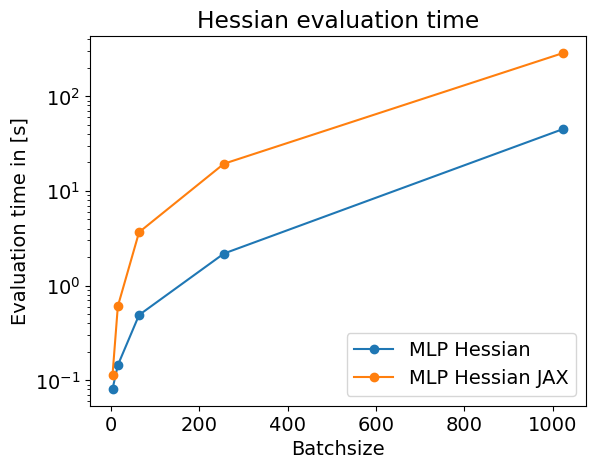

In [16]:
batchsizes = [4, 16, 64, 256, 1024]
fig, ax = plt.subplots()
ax.plot(batchsizes, runtimes, label="MLP Hessian", marker="o")
ax.plot(batchsizes, jax_runtimes, label="MLP Hessian JAX", marker="o")
ax.set_xlabel("Batchsize")
ax.set_ylabel("Evaluation time in [s]")
ax.set_title("Hessian evaluation time")

ax.set_yscale("log")
ax.legend(loc="lower right")

  0%|          | 0/1000 [00:00<?, ?it/s]

ValueError: Supplied order is missing vertices {74}!

### Best result so far
fwd mean: 3.8236873149871826, rev mean: 3.6495230197906494, cc_mean: 2.9825470447540283, mM_mean: 3.825319290161133
fwd std: 0.2087354212999344, rev std: 0.39476415514945984, cc_std: 0.6004145741462708, mM_std: 0.47684094309806824

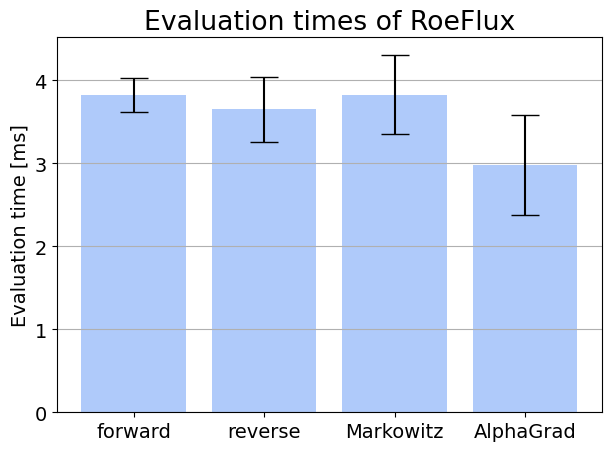